In [19]:
import numpy as np
import matplotlib.pyplot as pl
import scipy as sp
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sb
from scipy.integrate import quad
import math

#takes 4.5 +- 0.5 mins to run sim.test_multidim(30, 10)

#trial 2 change: f 0.1 -> 0.9
#trial 3 change>: f 0.1 -> 0.5
#trial 4 change: mean_false 201 -> 120
#trial 5 change: stdev_false 2 -> 20

class Simulation: 
    #return y position on a normal curve
    def __init__(self):
        self._environment = {
            'mean_real' : 200,
            'mean_false' : 201,
            'stdev_real' : 2,
            'stdev_false' : 2,
            'f' : 0.1}
        self._observer = {
            'mean_real' : 200,
            'mean_false' : 201,
            'stdev_real' : 2,
            'stdev_false' : 2,
            'f' : 0.1}
    
    def test_unidim(self, T = 1000):
        self._graph_env()
        observations, u = self._generate_env(T = 1000)
        c = self._classify(observations)
        Simulation._graph_classifications(observations, c)
        print(Simulation._accuracy_summary(u, c))
    
    def test_multidim(self, max_vector_size = 30, trials_per_size = 10):
        data = np.ndarray((trials_per_size, max_vector_size))

        for vector in np.arange(max_vector_size):
            for trial in np.arange(trials_per_size):
                obs, y_t = self._generate_env(T = 1000, vector_size = vector+1)
                data[trial][vector] = Simulation._acc_rate(y_t, self._classify(obs))
        Simulation._accuracy_summary_multidim(pd.DataFrame(data, columns = np.arange(1, max_vector_size + 1)))

    @staticmethod
    def _rho(o, mean, stddev):
	    return np.exp(-(o-mean)**2/(2*stddev**2))/np.sqrt(2*np.pi*stddev**2)
    
    def set_environment(self, newenv):
        self._environment = newenv
    def set_observer(self, newobs):
        self._observer = newobs

    def _graph_env(self):
        # np.linspace defines x axis of line graph; 1000 means 1000 intervals (resolution of plot); 190-210 or 150-250
        means = (self._environment["mean_real"], self._environment["mean_false"])
        stdevs = (self._environment["stdev_real"], self._environment["stdev_false"])
        
        xmin = np.amin(means) - 5*np.amax(stdevs)
        xmax = np.amax(means) + 5*np.amax(stdevs)

        os = np.linspace(xmin,xmax,1000)
        # creates placeholder array of zeros to hold y axs values
        phirs = np.zeros(len(os))
        phifs = np.zeros(len(os))
        # fill out y values; no need for brackets, just tabs?
        for t in range(len(os)):
	        phirs[t] = Simulation._rho(os[t], means[0], stdevs[0])
	        phifs[t] = Simulation._rho(os[t], means[1], stdevs[1])

        stylesheet1 = {
            "axes.labelsize" : 26,
            "xtick.labelsize" : 26,
            "ytick.labelsize" : 26,
            "figure.figsize" : (9, 5),
            'font.family' : 'serif',
        }

        with pl.style.context(stylesheet1):
            pl.plot(os,phirs, label = "PDF, real observations")
            pl.plot(os,phifs, label = "PDF, false observations")
        pl.locator_params(axis='y', nbins=6)
        #pl.legend(loc = "best")
        pl.ylabel("Probability density")
        pl.xlabel ("Observations (ot)")
        pl.show()

    def graph_env_obs(self):
        means = (self._observer["mean_real"], self._observer["mean_false"], self._environment["mean_real"], self._environment["mean_false"],)
        stdevs = (self._observer["stdev_real"], self._observer["stdev_false"], self._environment["stdev_real"], self._environment["stdev_false"])
        
        xmin = np.amin(means) - 5*np.amax(stdevs)
        xmax = np.amax(means) + 5*np.amax(stdevs)
        os = np.linspace(xmin,xmax,1000)

        # creates placeholder array of zeros to hold y axs values
        e_rhor_y = np.zeros(len(os))
        e_rhof_y = np.zeros(len(os))
        o_rhor_y = np.zeros(len(os))
        o_rhof_y = np.zeros(len(os))
        # fill out y values; no need for brackets, just tabs?
        for t in range(len(os)):
            o_rhor_y[t] = Simulation._rho(os[t], means[0], stdevs[0])
            o_rhof_y[t] = Simulation._rho(os[t], means[1], stdevs[1])
            e_rhor_y[t] = Simulation._rho(os[t], means[2], stdevs[2])
            e_rhof_y[t] = Simulation._rho(os[t], means[3], stdevs[3])

        stylesheet1 = {
            "axes.labelsize" : 26,
            "xtick.labelsize" : 26,
            "ytick.labelsize" : 26,
            "figure.figsize" : (9, 5),
            'font.family' : 'serif',
        }

        with pl.style.context(stylesheet1):
            pl.plot(os, e_rhor_y, label = "PDF, real observations")
            pl.plot(os, e_rhof_y, label = "PDF, false observations")
            pl.plot(os, o_rhor_y, label = "PDF, real observations", color = "green", linewidth = 5)
            pl.plot(os, o_rhof_y, label = "PDF, false observations", color = "red", linewidth = 5)
        pl.locator_params(axis='y', nbins=6)
        #pl.legend(loc = "best")
        pl.ylabel("Probability density")
        pl.xlabel ("Observations (ot)")
        pl.show()


    def _generate_env(self, T, vector_size=1):
        # 1. Randomly decide if we are hallucinating or not
        # 2. If hallucinating, draw an observation from a normal distribution specified by phi_false
        # 3. If not, draw an observation from a normal distribution specified by phi_real
        # 4. add this observation to the list of observations.
        observations = np.ndarray((T, vector_size))

        # choose if we are hallucinating or not
        u = np.random.binomial(n=1, p=self._environment["f"], size=T)
        for t in np.arange(T): 
            # do an if statement to "case it out"
            if u[t]==0:
                # draw from real()
                for v in np.arange(vector_size):
                    o = np.random.normal(self._environment["mean_real"],self._environment["stdev_real"])
                    observations[t][v] = o
            else:
                # draw from false
                for v in np.arange(vector_size):
                    o = np.random.normal(self._environment["mean_false"],self._environment["stdev_false"])
                    observations[t][v] = o
        return observations, u #observations is array of 1000 rows, 30 columns, if T = 1000 and vector size = 30
    
    @staticmethod
    def _graph_observations(observations):
        pl.hist(observations, 100)
        pl.xlabel("Observations (ot)")
        pl.ylabel("Frequency")
    
    def _classify(self, observations):
        
        results = np.ndarray((1000,), dtype = np.bool) #array filled w/ junk values
        mean_real = self._observer["mean_real"]
        stdev_real = self._observer["stdev_real"] 
        mean_false = self._observer["mean_false"]
        stdev_false = self._observer["stdev_false"]  
        f = self._observer["f"] 

        #calculating L; L starts as ratio of priors, then ratio of likelihoods for each vector component
        for vector in np.arange(observations.shape[0]):
            L = (1-f)/f
            for component in np.arange(observations.shape[1]):
                L *= ( Simulation._rho(observations[vector][component],mean_real,stdev_real) / Simulation._rho(observations[vector][component],mean_false,stdev_false) )
            results[vector] = (L>1)
        return results #should be 1 row, 1000 col array of bools

    @staticmethod
    def _acc_rate(y_true, y_pred):
        #accuracy_score(y_true, y_pred) this method takes observations for y_true, classificatons for y_pred
        foo = accuracy_score(y_true, y_pred, normalize=False)
        return 100-(100*foo/1000)
        #foo is the inverse of what it should be: u_real represented as 0, while c_real represented as True; accuracy counts discrepancies of u, c
    
    @staticmethod
    def _accuracy_summary(u, c) :
        print("actually real: ",len(u[u==0])," classified as real: ",len(c[c==1]))
        print("accuracy rate: ", Simulation._acc_rate(u, c))

        #true positive
        cr = u[c] #list of u for which corresponding index in c holds True
        ur_cr  = cr[cr == 0]
        print("true positive rate: ", len(ur_cr)/len(u[u == 0]) )
        
        #false positive
        cr = u[c]
        #print(len(cr))
        uf_cr  = cr[cr == 1]
        print("false positive rate: ", len(uf_cr)/len(u[u == 1]) )

        #false negative
        cf = u[~c]
        ur_cf  = cf[cf == 0]
        print("false negative rate: ", len(ur_cf)/len(u[u == 0]) )
    
    @staticmethod
    def _graph_classifications(observations, c):

        obs_real = observations[c]
        obs_false = observations[~c] 

        stylesheet2 = {
            #"axes.titlesize" : 24,
            "axes.labelsize" : 26,
            #lines.linewidth : 3,
            #"lines.markersize" : 10,
            "xtick.labelsize" : 26,
            "ytick.labelsize" : 26,
            "figure.figsize" : (9, 5),
            'font.family' : 'serif',
            #'font.weight' : 50,
            #'font.serif' : ['Times New Roman'],
        }

        if len(obs_real) != 0:
            intervals_r = round(100*(np.ptp(obs_real)/np.ptp(observations)))
            with pl.style.context(stylesheet2):
                pl.hist(obs_real,intervals_r, label="Observations classified as real")    
        if len(obs_false) != 0:
            intervals_f = round(100*(np.ptp(obs_false)/np.ptp(observations)))
            with pl.style.context(stylesheet2):
                pl.hist(obs_false,intervals_f, label="Observations classified as hallucinations", color = 'orange')

        #pl.legend(loc="best")
        pl.ylabel("Frequency")
        pl.xlabel("Observations (ot)")
    
    @staticmethod
    def _accuracy_summary_multidim(data):
        stylesheet_halfwidth = {
            #"axes.titlesize" : 24,
            "axes.labelsize" : 20,
            #lines.linewidth : 3,
            #"lines.markersize" : 10,
            "xtick.labelsize" : 20,
            "ytick.labelsize" : 20,
            "figure.figsize" : (9, 5),
            'font.family' : 'serif',
            #'font.weight' : 50,
            #'font.serif' : ['Times New Roman'],
        }
        stylesheet_thirdwidth = {
            #"axes.titlesize" : 24,
            "axes.labelsize" : 26,
            #lines.linewidth : 3,
            #"lines.markersize" : 10,
            "xtick.labelsize" : 26,
            "ytick.labelsize" : 26,
            "figure.figsize" : (8, 5),
            'font.family' : 'serif',
            #'font.weight' : 50,
            #'font.serif' : ['Times New Roman'],
        }
        with pl.style.context(stylesheet_thirdwidth):
            axes = sb.boxplot(data=data)
        if len(axes.get_xticklabels()) > 15:
            for ind, label in enumerate(axes.get_xticklabels()):
                if ind % 3 == 2:  # every odd-index label (these labels are even #s though) is kept
                    label.set_visible(True)
                else:
                    label.set_visible(False)
        axes.set(xlabel='Vector Size', ylabel='Accuracy Rate')

#kullback leibler divergence; measure of difference between 2 distributions (but here i have 3... and i get negative results, when KL divergence is supposed to be non-negative...)
    def divergence_metric(self):

        xs = np.linspace(150,250,1000)
        yrs = np.zeros(len(xs))
        yfs = np.zeros(len(xs))

        def integrand_r(o):
            exp1 = Simulation._rho(o, self._environment["mean_real"], self._environment["stdev_real"])
            exp2 = Simulation._rho(o, self._observer["mean_real"], self._observer["stdev_real"])
            exp3 = Simulation._rho(o, self._observer["mean_false"], self._observer["stdev_false"])
            return exp1*(math.log(exp2/exp3))
        def integrand_f(o):
            exp1 = Simulation._rho(o, self._environment["mean_false"], self._environment["stdev_false"])
            exp2 = Simulation._rho(o, self._observer["mean_false"], self._observer["stdev_false"])
            exp3 = Simulation._rho(o, self._observer["mean_real"], self._observer["stdev_real"])
            return exp1*(math.log(exp2/exp3))
        #def integrand_f(o):
            #return Simulatrho_false(o,mean_false,stdev_false)*(math.log(rho_false(o, mean_f_wrong, stdev_f_wrong)/rho_real(o, mean_r_wrong, stdev_r_wrong)))

        for t in range(len(xs)):
            yrs[t] = integrand_r(xs[t])
            yfs[t] = integrand_f(xs[t])

        # see what the integrand function even is; can't let the domain extend too far in either direction (<100 or i get a domain error; at some point, something changes?
        #pl.plot(xs,yrs)
        #pl.plot(xs,yfs)
        #pl.xlabel ("Observations (ot)")
        #pl.show()

        answer, error = quad(integrand_r, 180, 220)
        i1, i2 = quad(integrand_f, 180, 220)
        #answer, error = quad(integrand, -1*(math.inf), math.inf)

        print(answer, error)
        print(i1, 12)

sim = Simulation()


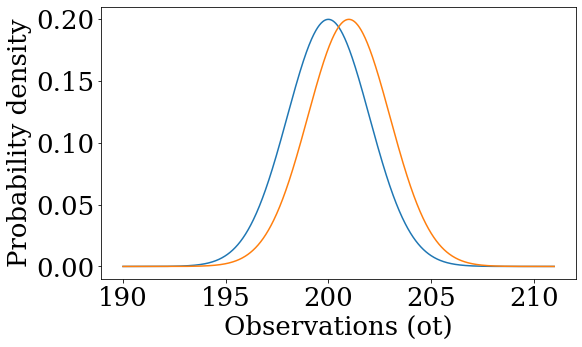

actually real:  497  classified as real:  513
accuracy rate:  60.8
true positive rate:  0.6217303822937625
false positive rate:  0.40556660039761433
false negative rate:  0.3782696177062374
None


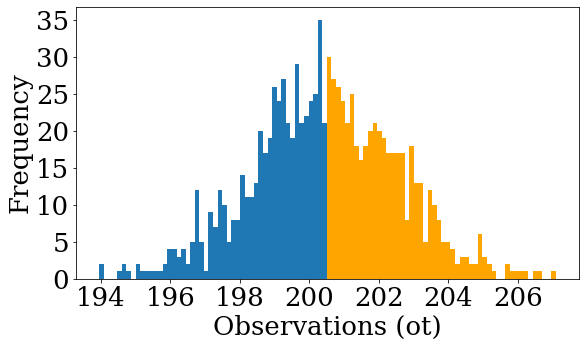

In [39]:
common_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.5}
sim.set_environment(common_properties)
sim.set_observer(common_properties)
sim.test_unidim()

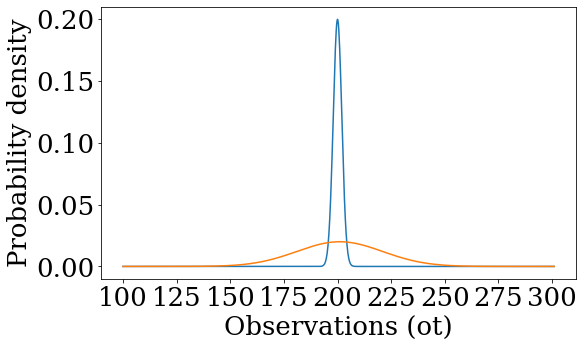

actually real:  902  classified as real:  935
accuracy rate:  96.5
true positive rate:  0.9988913525498891
false positive rate:  0.3469387755102041
false negative rate:  0.0011086474501108647
None


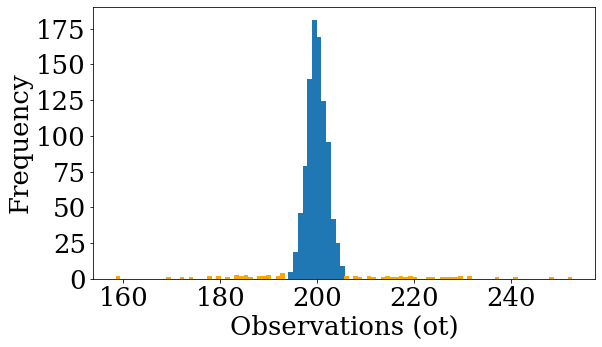

In [40]:
common_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 20,
    'f' : 0.1}
sim.set_environment(common_properties)
sim.set_observer(common_properties)
sim.test_unidim()

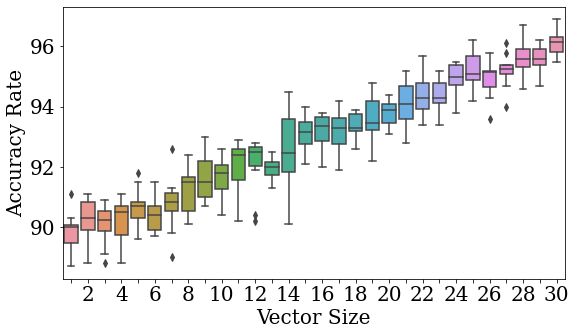

In [41]:
common_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.1}
sim.set_environment(common_properties)
sim.set_observer(common_properties)
sim.test_multidim(30, 10)

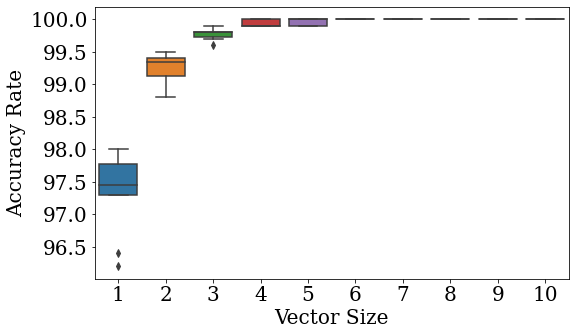

In [49]:
common_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 20,
    'f' : 0.1}
sim.set_environment(common_properties)
sim.set_observer(common_properties)
sim.test_multidim(10, 10)

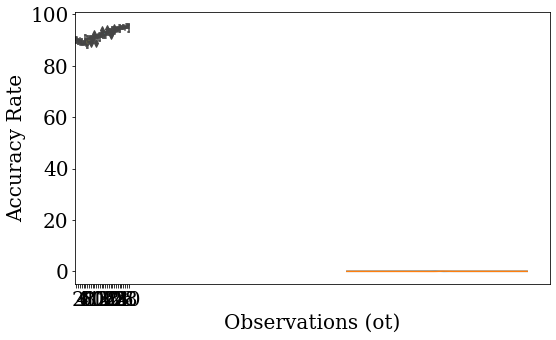

0.12500000000000017 1.1004342402153727e-08
0.12499999999999961 12


In [3]:
environment_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.1}
observer_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.2}
sim.set_environment(environment_properties)
sim.set_observer(observer_properties)
sim.test_multidim(30, 10)
sim.divergence_metric() #for some reason, the divergence-integrand graph ends up occupying same graph as boxplot
#how to fix this?

0.12500000000000017 1.1004342402153727e-08
0.12499999999999961 12


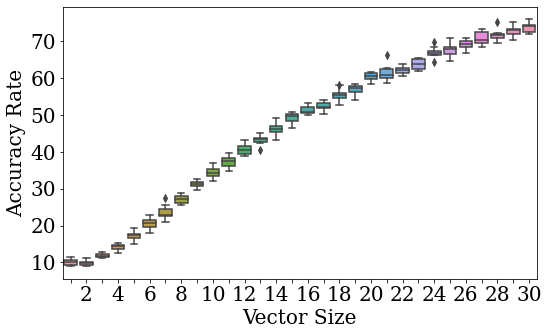

In [4]:
environment_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.1}
observer_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.9}
sim.set_environment(environment_properties)
sim.set_observer(observer_properties)
sim.test_multidim(30, 10)
sim.divergence_metric()

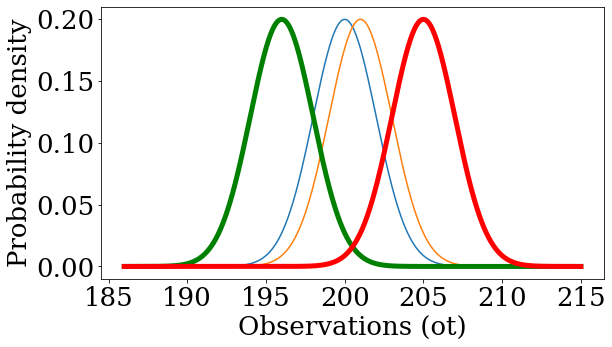

In [20]:
environment_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.1}
observer_properties = {
    'mean_real' : 196,
    'mean_false' : 205,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.1}
sim.set_environment(environment_properties)
sim.set_observer(observer_properties)
sim.graph_env_obs()
#sim.test_multidim(30, 10)
#sim.divergence_metric()

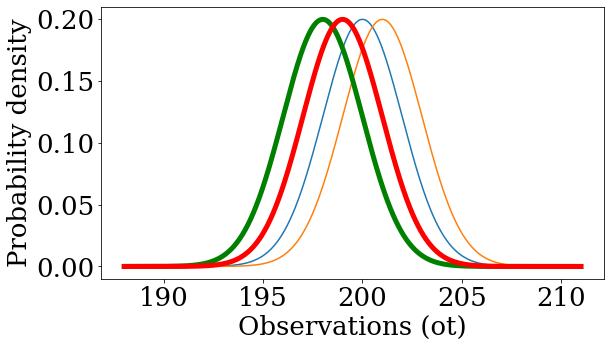

In [21]:
environment_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.1}
observer_properties = {
    'mean_real' : 198,
    'mean_false' : 199,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.1}
sim.set_environment(environment_properties)
sim.set_observer(observer_properties)
sim.graph_env_obs()
#sim.test_multidim(30, 10)
#sim.divergence_metric()

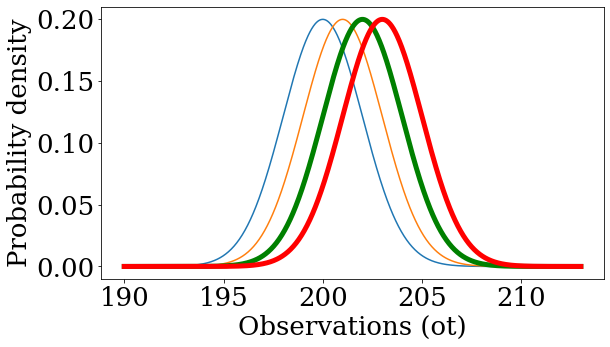

In [22]:
environment_properties = {
    'mean_real' : 200,
    'mean_false' : 201,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.1}
observer_properties = {
    'mean_real' : 202,
    'mean_false' : 203,
    'stdev_real' : 2,
    'stdev_false' : 2,
    'f' : 0.2}
sim.set_environment(environment_properties)
sim.set_observer(observer_properties)
sim.graph_env_obs()
#sim.test_multidim(30, 10)
#sim.divergence_metric()